# Cell level classifiers using ResNet-18 trained from scratch

## Classification between largest cancer types and healthy

Include healthy in objective as it is shared across plates and cancer types classification could cheat using plate effect.

In [1]:
import importlib 
import util, models, training, eval

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)
importlib.reload(eval)

<module 'eval' from '/home/unix/hschluet/projects/pt-pbmc/eval.py'>

In [2]:
from data import PlateDataset
from util import torch_random_choice
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns

device = 'cuda:7'

In [3]:
data = PlateDataset([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.90it/s]


In [4]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,3,A02,0,5,P115,2,True,H&N cancer
1,3,A02,0,6,P115,2,True,H&N cancer
2,3,A02,0,9,P115,2,True,H&N cancer
3,3,A02,0,12,P115,2,True,H&N cancer
4,3,A02,0,18,P115,2,True,H&N cancer
...,...,...,...,...,...,...,...,...
682024,12,H12,8,56,P118,5,True,Chordoma/Chondrosarcoma
682025,12,H12,8,84,P118,5,True,Chordoma/Chondrosarcoma
682026,12,H12,8,85,P118,5,True,Chordoma/Chondrosarcoma
682027,12,H12,9,55,P118,5,True,Chordoma/Chondrosarcoma


In [5]:
data.info.groupby(['plate', 'group'])['cell'].count()

plate  group                  
3      H&N cancer                 15259
       healthy                     1717
4      H&N cancer                 88198
       healthy                     8861
5      H&N cancer                 15530
       healthy                     1661
6      H&N cancer                 64118
       healthy                     4591
7      CNS-Meningioma             88192
       healthy                    13659
8      CNS-Meningioma             32397
       Lymphoma                   46938
       healthy                     9107
9      CNS-Meningioma             18910
       healthy                     4418
10     Chordoma/Chondrosarcoma    70034
       healthy                     5830
11     Chordoma/Chondrosarcoma    39004
       healthy                     2445
12     CNS-Ependymoma             80228
       Chordoma/Chondrosarcoma    43113
       healthy                    10337
Name: cell, dtype: int64

In [6]:
data.info.groupby(['plate', 'group'])['patient'].unique()

plate  group                  
3      H&N cancer                  [P115, P72, P50, P67, P100, P77, P56, P125, P41]
       healthy                                                 [H06, H30, H23, H07]
4      H&N cancer                 [P129, P137, P107, P114, P149, P79, P120, P145...
       healthy                                                 [H40, H10, H30, H23]
5      H&N cancer                 [P148, P78, P63, P24, P18, P135, P12, P142, P161]
       healthy                                                 [H40, H31, H10, H39]
6      H&N cancer                 [P94, P166, P147, P14, P154, P55, P44, P98, P1...
       healthy                                                 [H31, H22, H37, H39]
7      CNS-Meningioma             [P102, P119, P70, P105, P59, P128, P48, P134, ...
       healthy                                                 [H22, H37, H26, H47]
8      CNS-Meningioma                                         [P162, P37, P42, P27]
       Lymphoma                              

In [7]:
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma']
cdf = data.info[data.info['group'].isin(use_groups)].groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H06', 'H07', 'H09', 'H10', 'H16', 'H19', 'H20', 'H22', 'H23',
       'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36', 'H37', 'H39',
       'H40', 'H43', 'H47', 'H49', 'P102', 'P105', 'P106', 'P107', 'P110',
       'P112', 'P114', 'P115', 'P118', 'P119', 'P120', 'P125', 'P126',
       'P128', 'P129', 'P130', 'P131', 'P134', 'P135', 'P137', 'P138',
       'P14', 'P142', 'P143', 'P144', 'P145', 'P147', 'P148', 'P149',
       'P152', 'P154', 'P155', 'P160', 'P161', 'P162', 'P163', 'P165',
       'P166', 'P18', 'P21', 'P23', 'P24', 'P25', 'P27', 'P33', 'P37',
       'P38', 'P42', 'P43', 'P44', 'P48', 'P55', 'P59', 'P62', 'P63',
       'P67', 'P69', 'P70', 'P72', 'P76', 'P78', 'P79', 'P83', 'P86',
       'P90', 'P92', 'P94', 'P98', 'P99'], dtype=object)

In [8]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma              7
CNS-Meningioma             19
Chordoma/Chondrosarcoma    21
H&N cancer                 37
Lymphoma                    7
healthy                    22
Name: patient, dtype: int64

In [14]:
use_plates = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
short_groups = {'healthy' : 'H', 'H&N cancer' : 'H&N', 'CNS-Meningioma' : 'M', 
                'Chordoma/Chondrosarcoma' : 'C/C'}  
group_map = {'healthy' : 0, 'H&N cancer' : 1, 'CNS-Meningioma' : 2, 'Chordoma/Chondrosarcoma' : 3} 


def group_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, 
                    transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['group'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    labels = []
    xs = []
    for label in use_groups:
      pat = np.random.choice(pat_groups[label])
      xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
      labels.extend([group_map[label]] * bag_size)
    yield torch.cat(xs).float().repeat(1, 3, 1, 1), torch.tensor(labels).to(device)


def test_group_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  pat_groups = data.info.groupby(['patient'])['group'].max()
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    xs = use_data[torch_random_choice(pat_idx, size=bag_size)]
    label = pat_groups[pat]
    yield xs.float().repeat(1, 3, 1, 1), torch.tensor(group_map[label]).to(device), pat, label

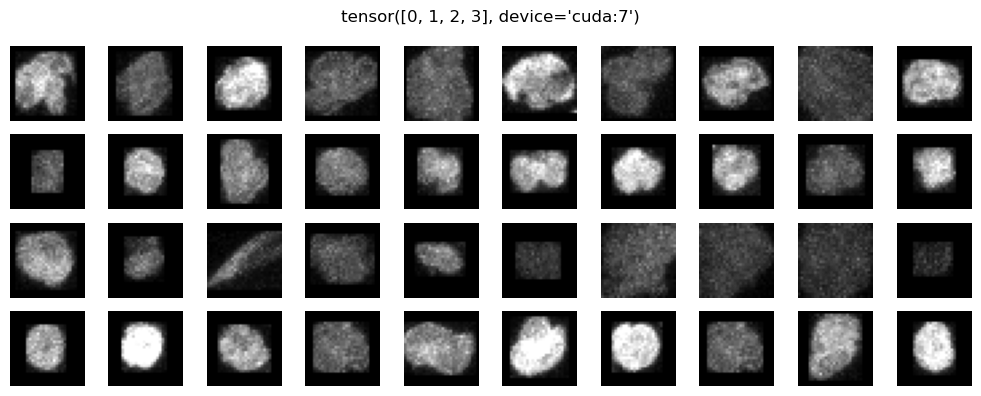

In [15]:
bag, lab = next(group_bagloader(bag_size=10))
fig, axs = plt.subplots(4, 10, figsize=(10, 4))
for im, ax in zip(bag, axs.flatten()):
  ax.imshow(im.squeeze().cpu()[0], cmap='gray', vmax=1, vmin=0)
  ax.axis('off')
fig.suptitle(lab.unique())
fig.tight_layout()
fig.show()

In [16]:
lab

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:7')

In [17]:
from torchvision.models import resnet18 as make_resnet18


def eval_model(name, loader, classes=5):
    model = make_resnet18(num_classes=classes).to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            prob = model(bag.to(device))
            pred = torch.argmax(prob, dim=-1)
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        # bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

### Big model

iter: 99999; train loss: 0.63357323; train error: 0.23500001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:22<00:00, 108.37it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_by_cell_resnet_from_scratch_model.pt


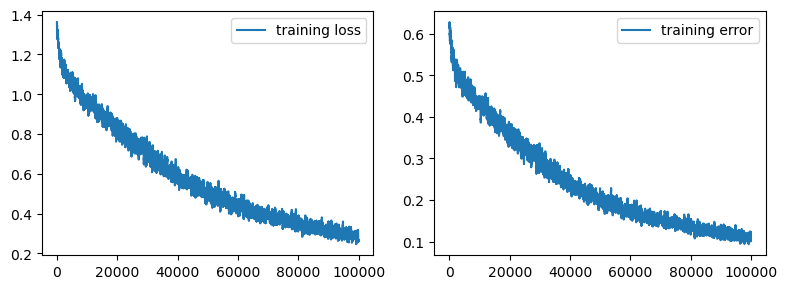

In [18]:
name = '3_12_t01_healthy_groups_by_cell_resnet_from_scratch'
train_loader = group_bagloader()
model = make_resnet18(num_classes=len(use_groups)).to(device)
df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341, use_model_objective=False, 
                 transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [19]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('3_12_t01_healthy_groups_by_cell_resnet_from_scratch', test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


,lab,pred,i,pat,group,plate
0,0,0,0,H06,healthy,3
1,0,0,0,H06,healthy,3
2,0,1,0,H06,healthy,3
3,0,0,0,H06,healthy,3
4,0,0,0,H06,healthy,3
...,...,...,...,...,...,...
10895,3,3,6,P21,Chordoma/Chondrosarcoma,12
10896,3,3,6,P21,Chordoma/Chondrosarcoma,12
10897,3,3,6,P21,Chordoma/Chondrosarcoma,12
10898,3,3,6,P21,Chordoma/Chondrosarcoma,12


In [20]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

,plate,pat,group,pred,counts
0,3,H06,H,H,90
1,3,H06,H,H&N,8
2,3,H06,H,C/C,2
3,3,H07,H,H,98
4,3,H07,H,H&N,2
...,...,...,...,...,...
356,12,P155,C/C,H,19
357,12,P155,C/C,H&N,10
358,12,P21,C/C,C/C,80
359,12,P21,C/C,M,17


/tmp/ipykernel_1241776/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_1241776/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_1241776/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_1241776

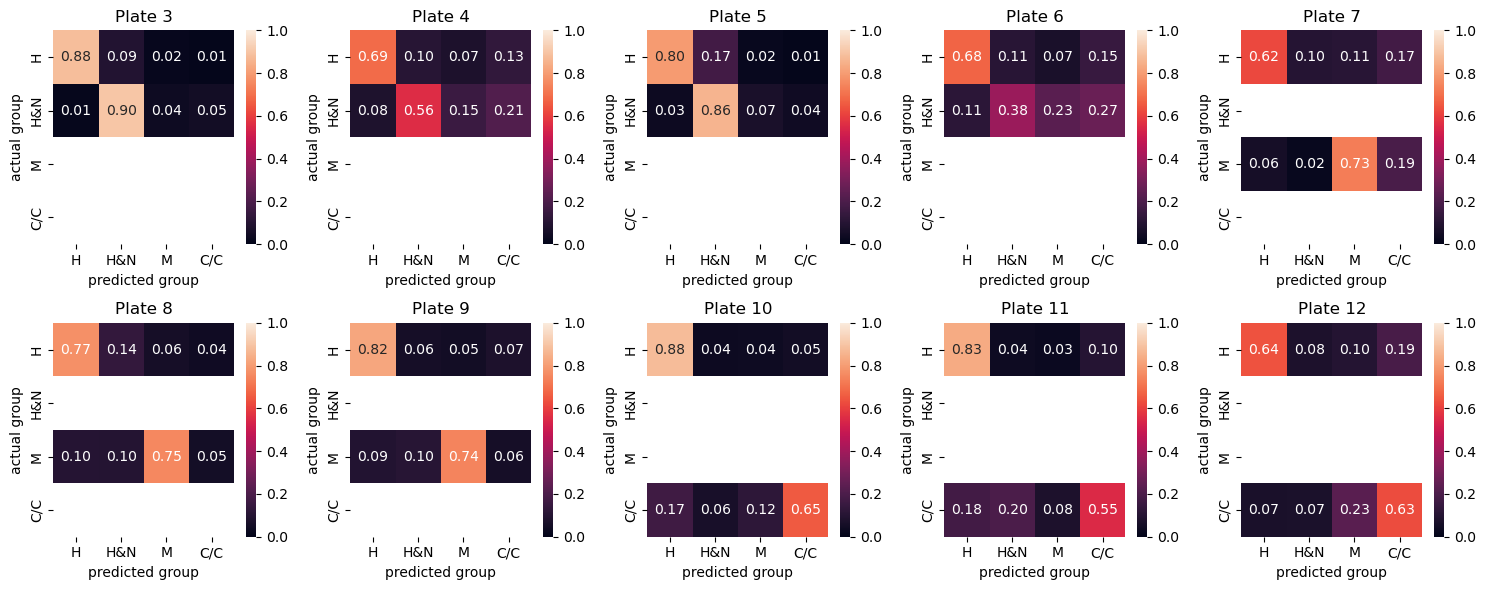

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_1241776/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


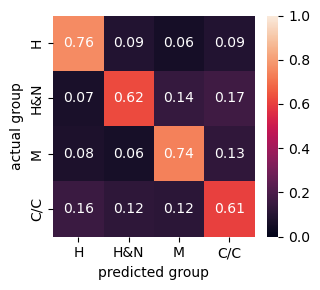

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

  0%|                                                                                                                                                                                      | 0/100000 [00:00<?, ?it/s]

iter: 99999; train loss: 0.43409351; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:32<00:00, 107.21it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_3_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.11953088; train error: 0.04500002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:12<00:00, 109.58it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_4_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.29497248; train error: 0.13499999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:12<00:00, 109.53it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_5_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.06085792; train error: 0.01500005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:07<00:00, 110.14it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_6_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.11873061; train error: 0.05000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:01<00:00, 110.90it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_7_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.13244972; train error: 0.05500001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:09<00:00, 109.92it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_8_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.19172187; train error: 0.06000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:20<00:00, 108.66it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_9_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.19251814; train error: 0.06500000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:06<00:00, 110.35it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_10_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.34848210; train error: 0.13499999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:58<00:00, 111.30it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_11_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.15220831; train error: 0.07500005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:08<00:00, 110.13it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_12_by_cell_resnet_from_scratch_model.pt


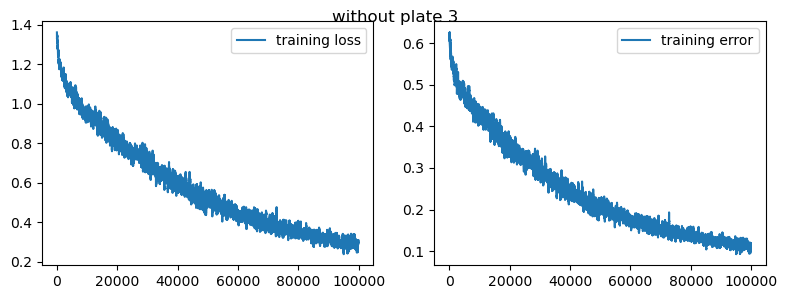

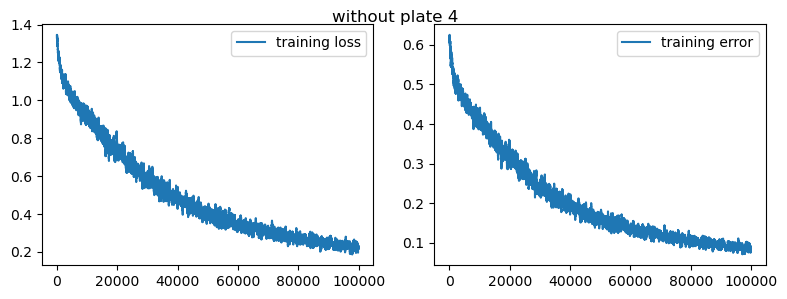

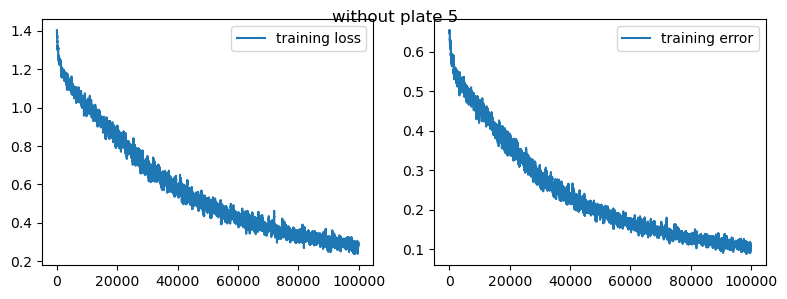

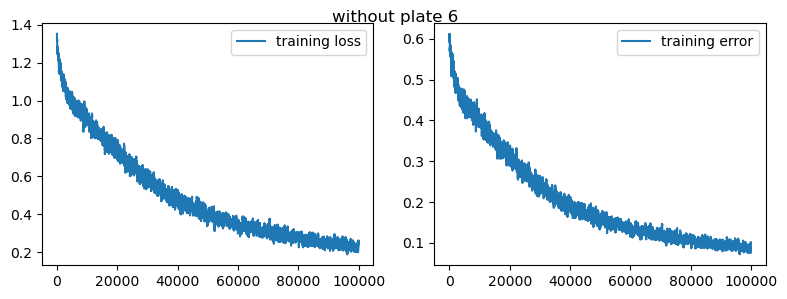

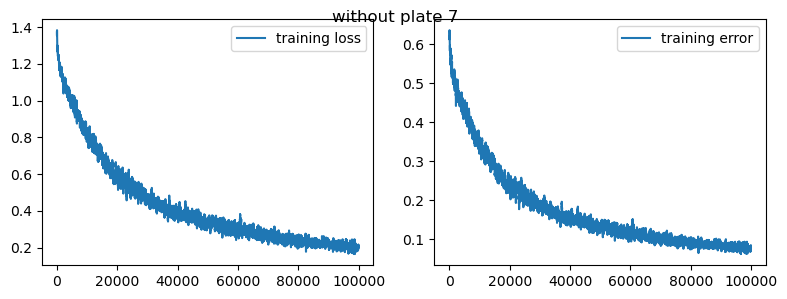

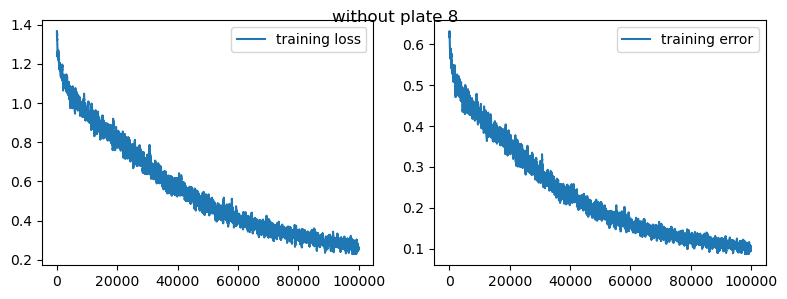

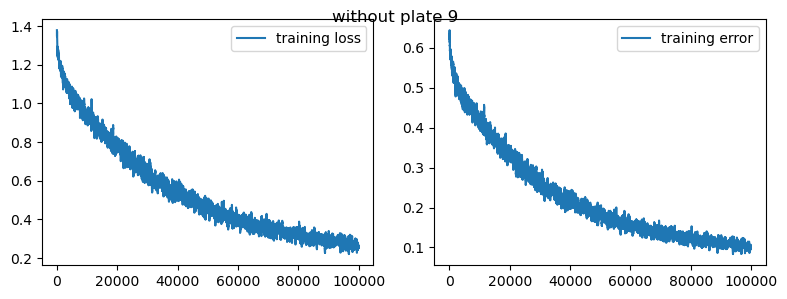

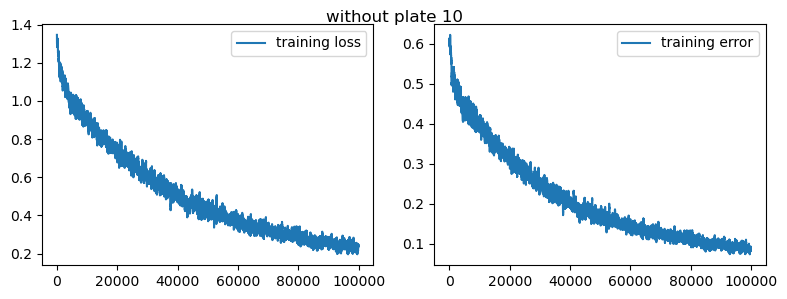

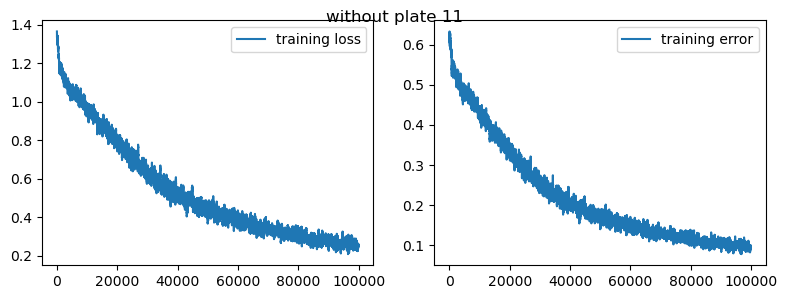

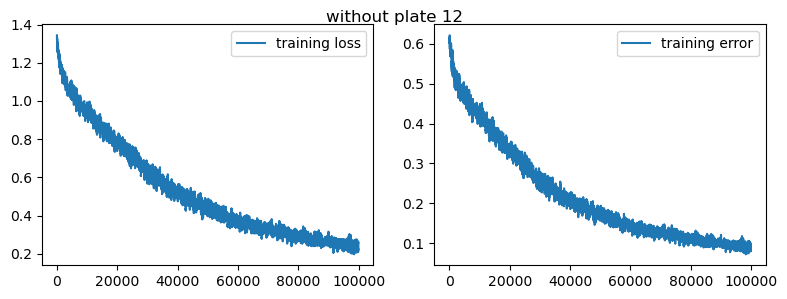

In [23]:
for plate in use_plates:
    name = f'3_12_t01_healthy_groups_without_plate_{plate}_by_cell_resnet_from_scratch'
    train_loader = group_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = make_resnet18(num_classes=len(use_groups)).to(device)
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                    save_model=True, seed=12341, use_model_objective=False,
                    transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [24]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'3_12_t01_healthy_groups_without_plate_{plate}_by_cell_resnet_from_scratch', 
                        test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


,lab,pred,i,pat,group,plate
0,0,0,0,H06,healthy,3
1,0,0,0,H06,healthy,3
2,0,0,0,H06,healthy,3
3,0,0,0,H06,healthy,3
4,0,0,0,H06,healthy,3
...,...,...,...,...,...,...
10895,3,2,6,P21,Chordoma/Chondrosarcoma,12
10896,3,3,6,P21,Chordoma/Chondrosarcoma,12
10897,3,3,6,P21,Chordoma/Chondrosarcoma,12
10898,3,1,6,P21,Chordoma/Chondrosarcoma,12


In [25]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

,plate,pat,group,pred,counts
0,3,H06,H,H,90
1,3,H06,H,C/C,6
2,3,H06,H,H&N,2
3,3,H06,H,M,2
4,3,H07,H,H,90
...,...,...,...,...,...
415,12,P155,C/C,C/C,17
416,12,P21,C/C,M,48
417,12,P21,C/C,C/C,32
418,12,P21,C/C,H&N,19


/tmp/ipykernel_1241776/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_1241776/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_1241776/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_1241776

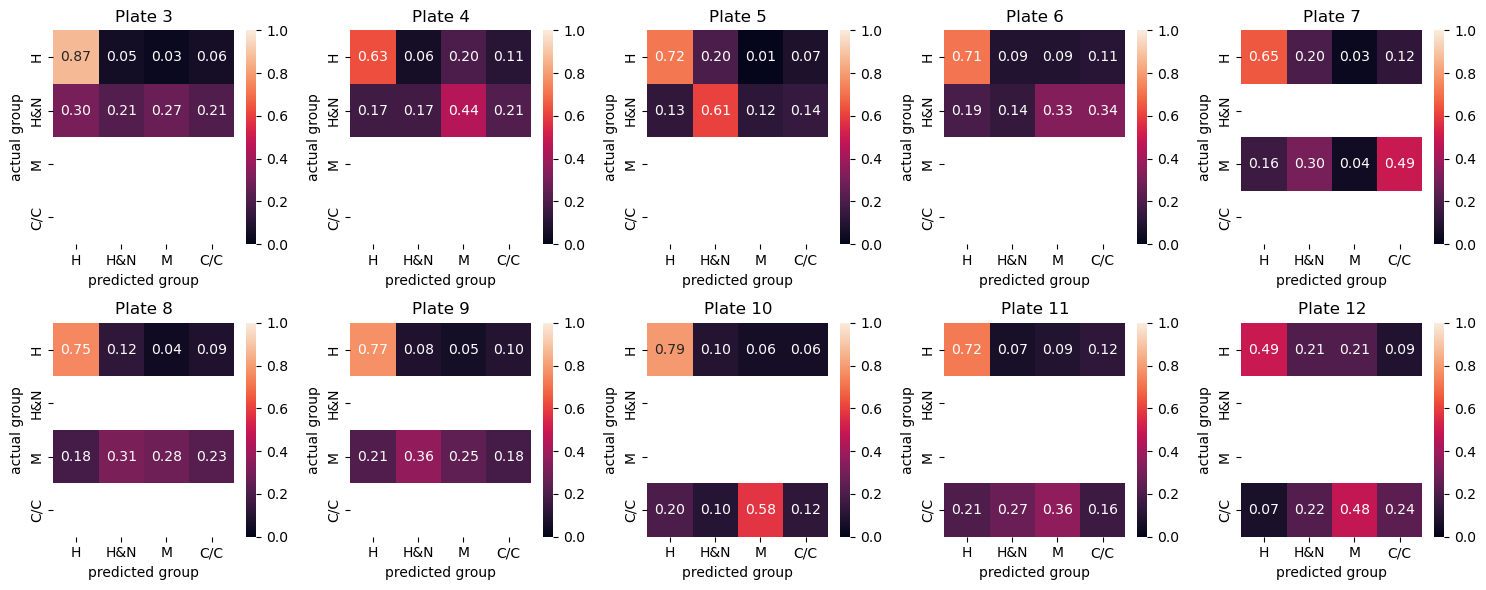

In [26]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_1241776/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


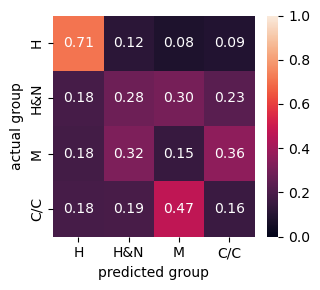

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

## Classification cancer T1 and healthy

In [66]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.02it/s]


In [67]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [68]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [69]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, 
                                transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size, dtype=int))
    
    labels = torch.cat(labels).to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]].repeat(1, 3, 1, 1), labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    label = 1 if pat[0] == 'H' else 0
    yield use_imgs[idx].float().repeat(1, 3, 1, 1), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [70]:
def eval_model(name, loader):
    model = make_resnet18(num_classes=2).to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            prob = model(bag.to(device))
            pred = torch.argmax(prob, dim=-1)
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        # bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [71]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0], device='cuda:7')

### Big model

iter: 99999; train loss: 0.55142564; train error: 0.31999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:05<00:00, 118.26it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_by_cell_resnet_from_scratch_model.pt


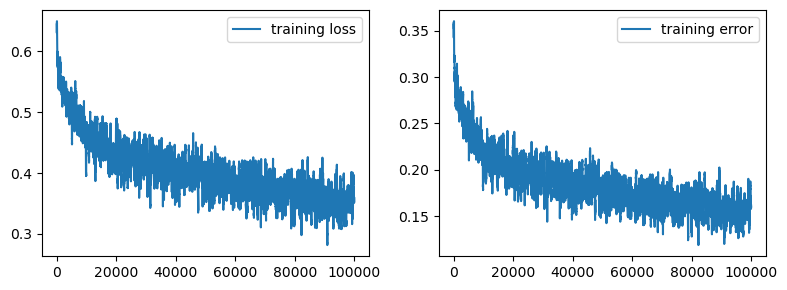

In [72]:
name = '1_16_t01_healthy_cancer_by_cell_resnet_from_scratch'
train_loader = healthy_vs_cancer_bagloader()
model = make_resnet18(num_classes=2).to(device)
df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341, use_model_objective=False,
                 transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [73]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('1_16_t01_healthy_cancer_by_cell_resnet_from_scratch', 
                         test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


,lab,pred,i,pat,group,plate
0,1,1,0,H01,healthy,1
1,1,1,0,H01,healthy,1
2,1,1,0,H01,healthy,1
3,1,1,0,H01,healthy,1
4,1,1,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0,11,P74,cancer,16
20196,0,0,11,P74,cancer,16
20197,0,0,11,P74,cancer,16
20198,0,0,11,P74,cancer,16


In [74]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1,96
1,1,H01,healthy,0,4
2,1,H02,healthy,1,98
3,1,H02,healthy,0,2
4,1,H03,healthy,1,100
...,...,...,...,...,...
393,16,P45,cancer,1,8
394,16,P61,cancer,0,75
395,16,P61,cancer,1,25
396,16,P74,cancer,0,96


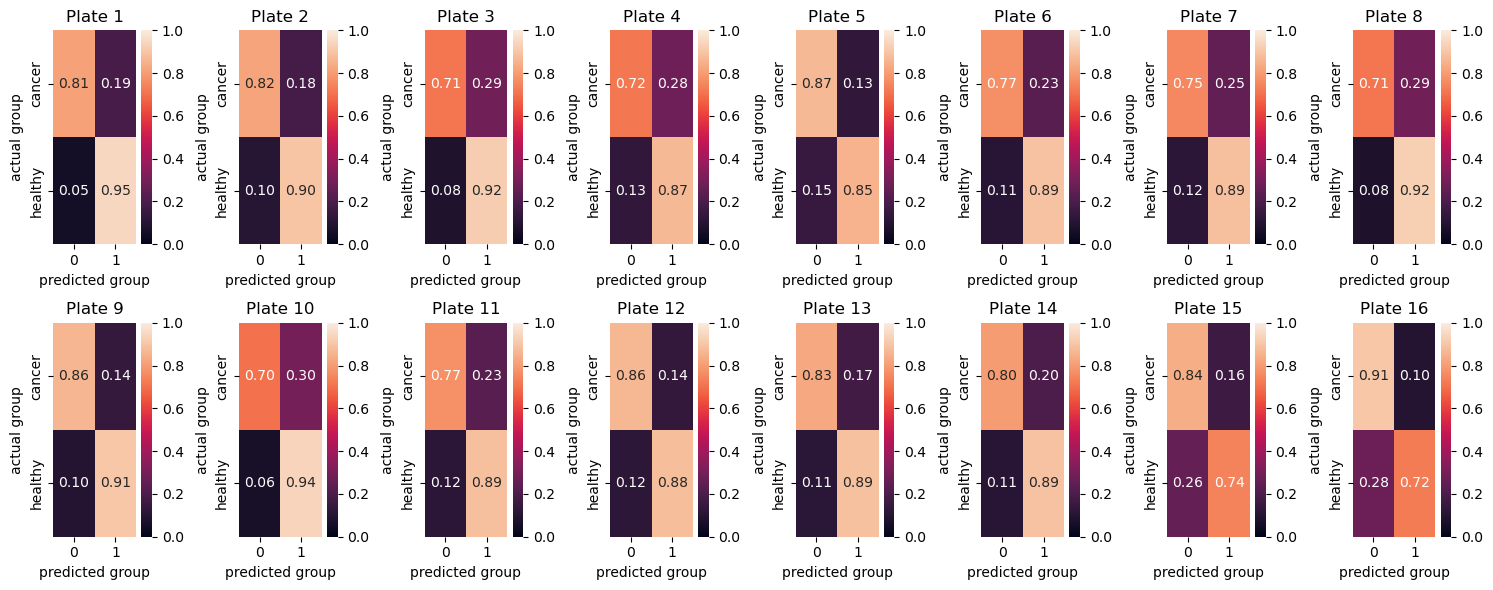

In [75]:
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

# pat_df['healthy'] = pat_df['healthy'].replace({True : 'H', False : 'C'})
# fig, axs = plt.subplots(2, 7, figsize=(10, 4), sharex=True, sharey=True)
# for ax, plate in zip(axs.flatten(), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]):
#     mat = pat_df[pat_df['plate'] == str(plate)].groupby('healthy')[['pred C %', 'pred H %']].mean(
#     ).rename(columns={'pred C %' : 'C', 'pred H %' : 'H'}).loc[['H', 'C'], ['H', 'C']]
#     sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_title(f'Plate {plate}')
# fig.tight_layout()

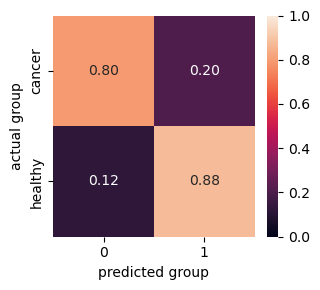

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

In [77]:
use_plates

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

iter: 99999; train loss: 0.40880951; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:49<00:00, 120.61it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_1_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.28017369; train error: 0.14000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:54<00:00, 119.89it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_2_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.37305129; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:55<00:00, 119.65it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_3_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.32605931; train error: 0.12000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:07<00:00, 118.06it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_4_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.41467533; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:08<00:00, 117.88it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_5_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.45452863; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:07<00:00, 117.94it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_6_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.36375633; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:03<00:00, 118.57it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_7_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.45439070; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:48<00:00, 120.65it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_8_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.32716587; train error: 0.14000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:47<00:00, 120.84it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_9_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.30392784; train error: 0.10000002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:43<00:00, 121.42it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_10_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.35229564; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:27<00:00, 115.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_11_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.53548074; train error: 0.31999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:52<00:00, 120.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_12_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.30874807; train error: 0.10000002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:55<00:00, 119.76it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_13_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.33108184; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:38<00:00, 113.81it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_14_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.39496884; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [15:00<00:00, 111.04it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_15_by_cell_resnet_from_scratch_model.pt


iter: 99999; train loss: 0.59044778; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:11<00:00, 117.38it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_16_by_cell_resnet_from_scratch_model.pt


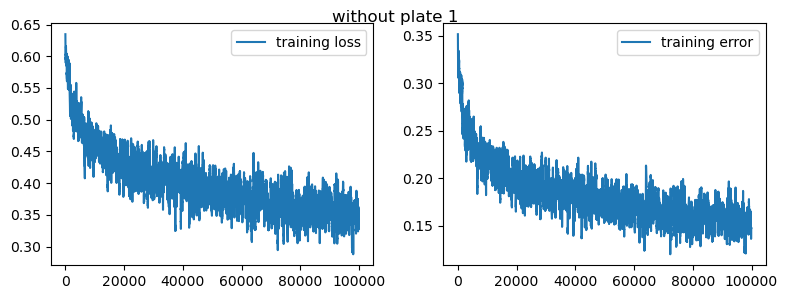

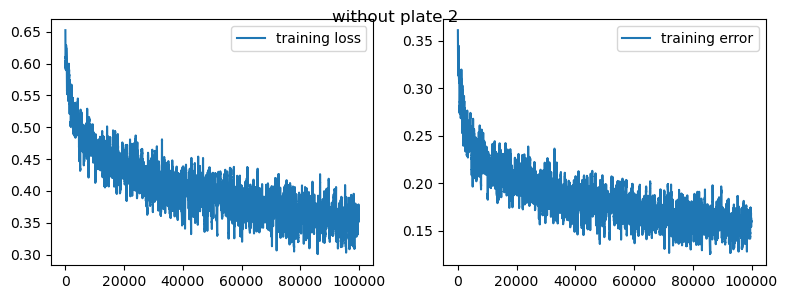

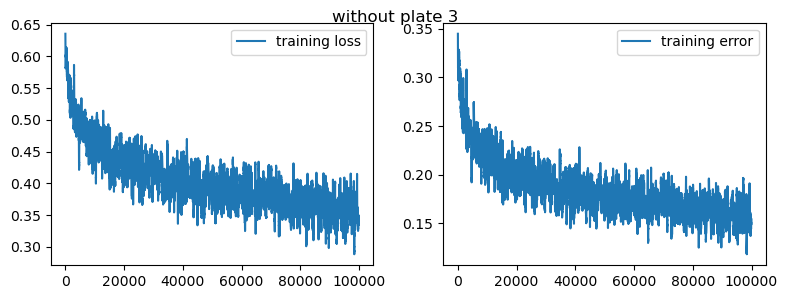

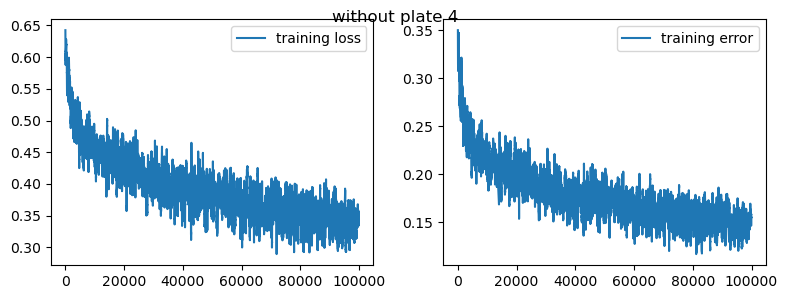

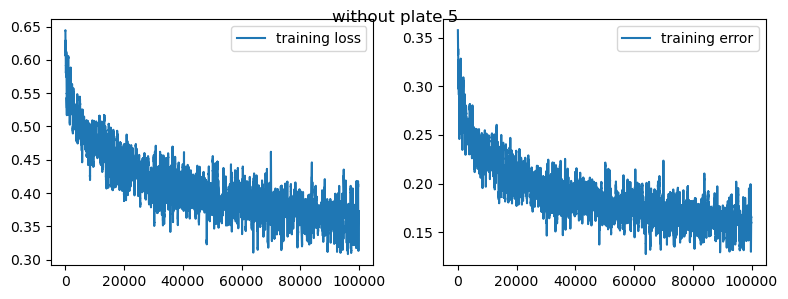

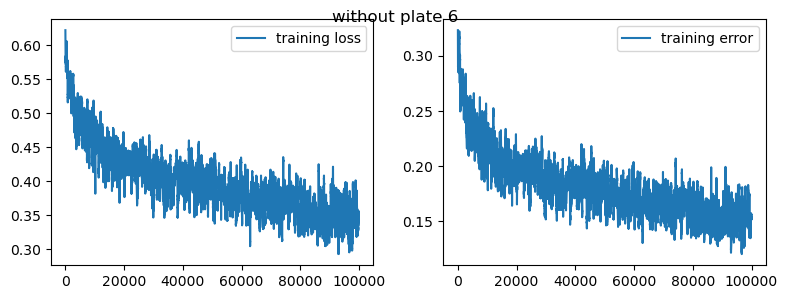

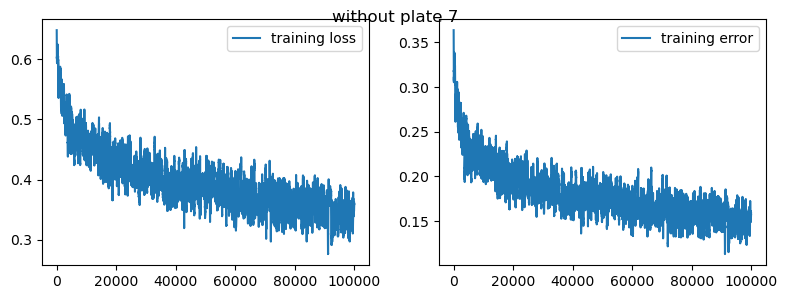

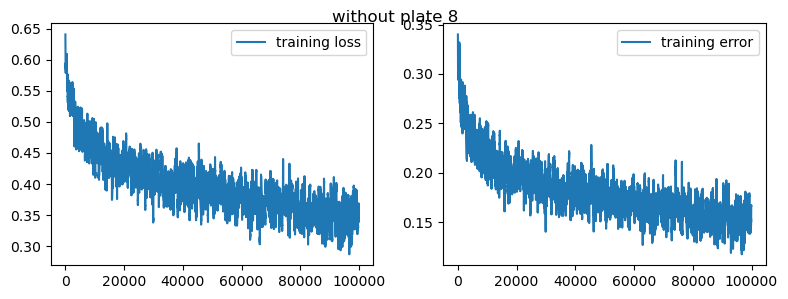

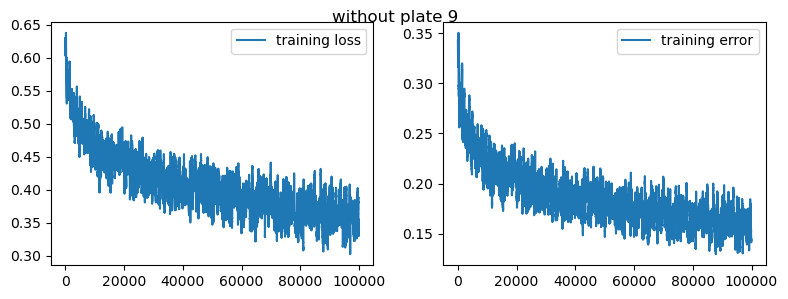

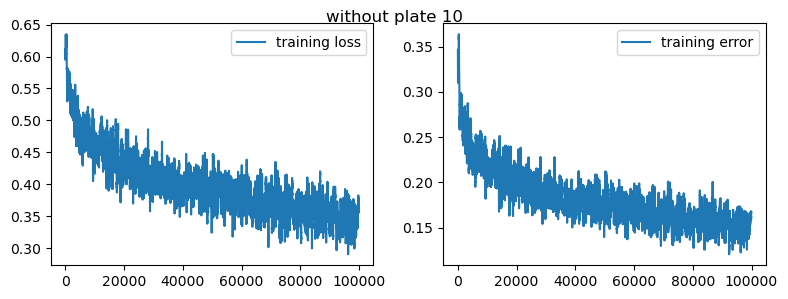

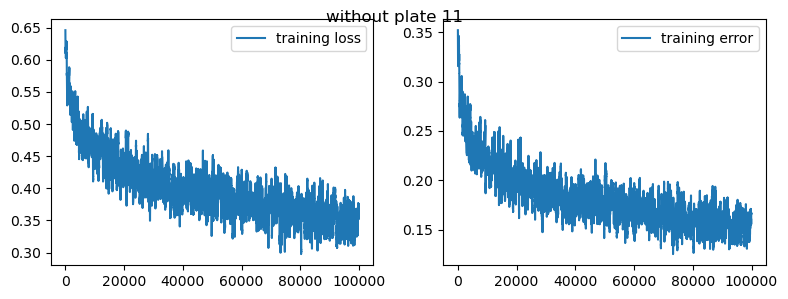

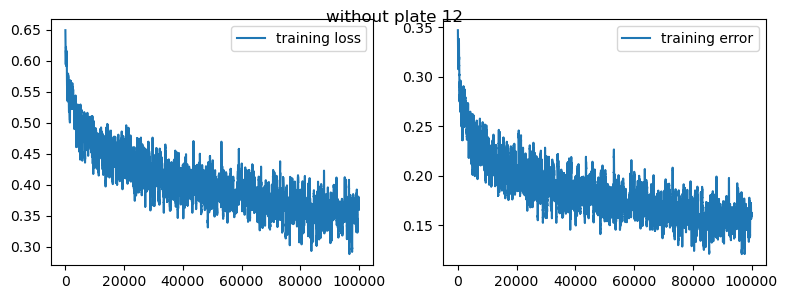

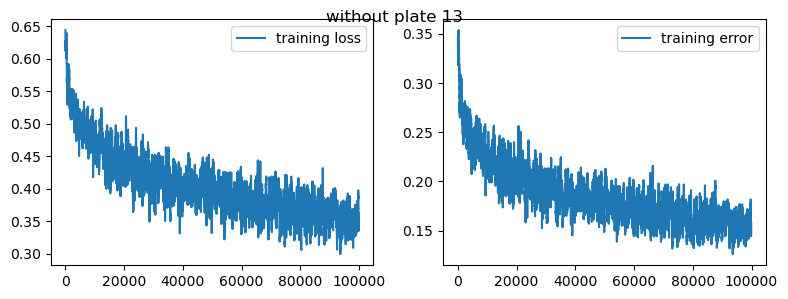

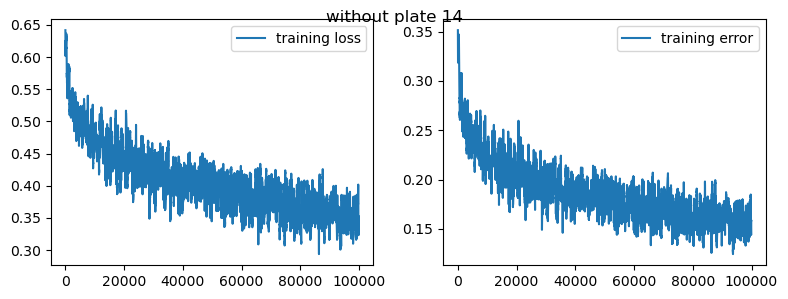

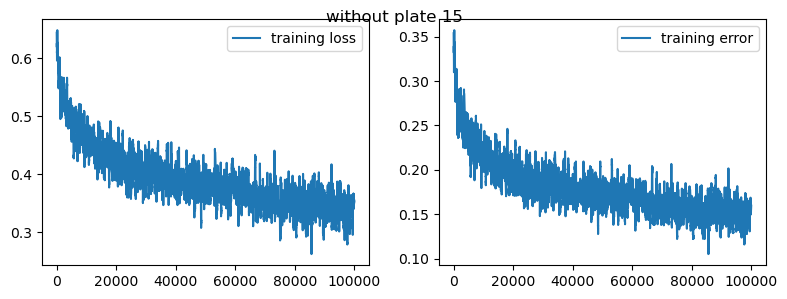

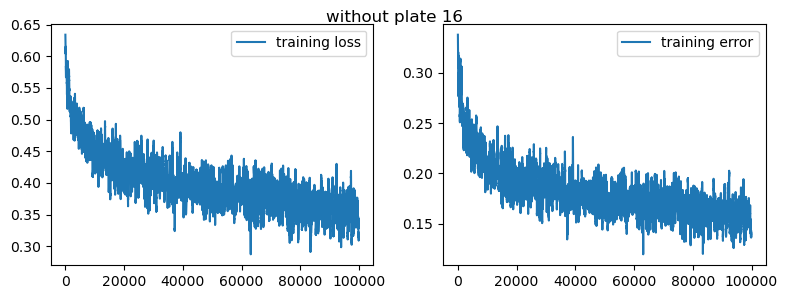

In [78]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_resnet_from_scratch'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = make_resnet18(num_classes=2).to(device)
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341, use_model_objective=False,
                     transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [79]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_resnet_from_scratch', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


,lab,pred,i,pat,group,plate
0,1,1,0,H01,healthy,1
1,1,1,0,H01,healthy,1
2,1,0,0,H01,healthy,1
3,1,1,0,H01,healthy,1
4,1,1,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0,11,P74,cancer,16
20196,0,0,11,P74,cancer,16
20197,0,0,11,P74,cancer,16
20198,0,0,11,P74,cancer,16


In [80]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
# pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
# pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1,69
1,1,H01,healthy,0,31
2,1,H02,healthy,1,87
3,1,H02,healthy,0,13
4,1,H03,healthy,1,81
...,...,...,...,...,...
363,16,P139,cancer,0,100
364,16,P151,cancer,0,100
365,16,P45,cancer,0,100
366,16,P61,cancer,0,100


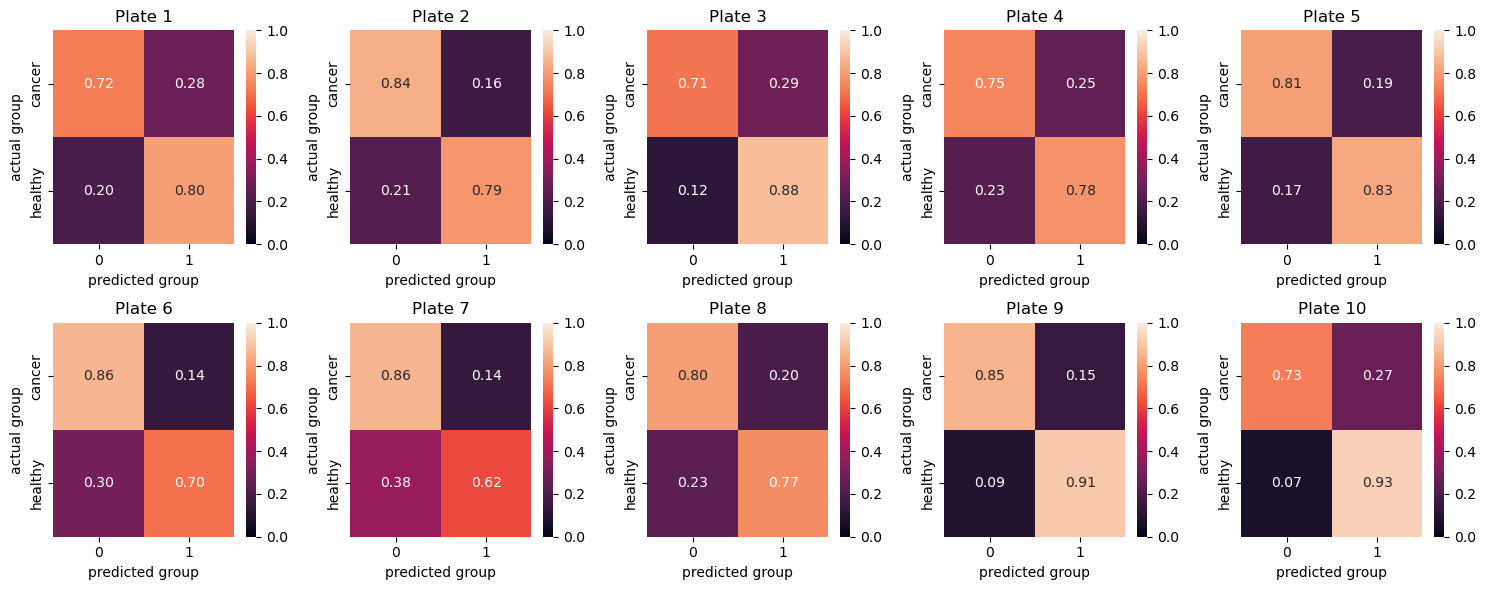

In [81]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

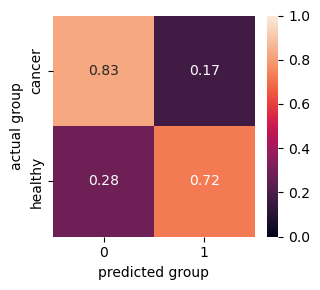

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [83]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

,plate,pat,group,pred
0,1,H01,healthy,0.69
1,1,H02,healthy,0.87
2,1,H03,healthy,0.81
3,1,H04,healthy,0.85
4,1,H05,healthy,0.79
...,...,...,...,...
197,16,P139,cancer,0.00
198,16,P151,cancer,0.00
199,16,P45,cancer,0.00
200,16,P61,cancer,0.00


In [84]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']

# pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
# pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
# pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
# pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
# pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
# pat_df.set_index(['plate', 'pat', 'group'])

plate_df

,plate,group,pred,H,C
0,1,C,0.275714,0.275714,0.724286
1,1,H,0.802000,0.802000,0.198000
2,2,C,0.158889,0.158889,0.841111
3,2,H,0.785000,0.785000,0.215000
4,3,C,0.290000,0.290000,0.710000
5,3,H,0.882500,0.882500,0.117500
6,4,C,0.253333,0.253333,0.746667
7,4,H,0.775000,0.775000,0.225000
8,5,C,0.192500,0.192500,0.807500
9,5,H,0.830000,0.830000,0.170000


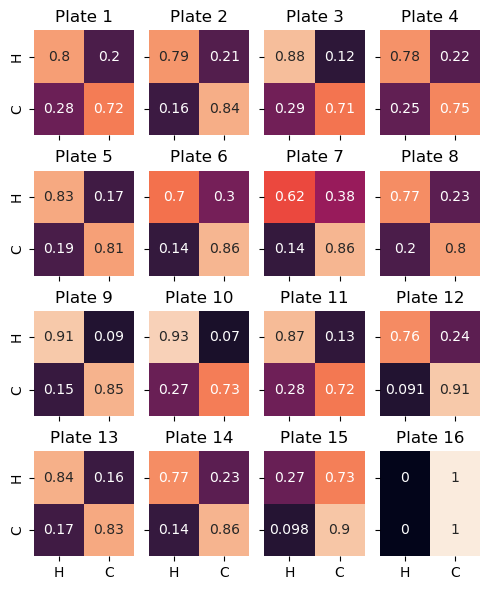

In [85]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = pat_df[pat_df['plate'] == plate].groupby(
    #     ['group', 'pred'])['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

In [86]:
print('done')

done
